In [0]:
from datetime import datetime, timezone, timedelta
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

NANO = 1e-9
ATTO = 1e-18
GiB = 2**30
TiB = 2**40
PiB = 2**50
ONE_DAY_EPOCH = 24 * 60 * 2
ONE_WEEK_EPOCH = ONE_DAY_EPOCH * 7
ONE_MONTH_EPOCH = ONE_DAY_EPOCH * 30


def height_to_unixepoch(height: int) -> int:
    return height * 30 + 1598306400

def height_to_timestamp(height: int) -> datetime:
    return datetime.fromtimestamp(height_to_unixepoch(height))

def unixepoch_to_height(timestamp):
    return (timestamp - 1598306400)/30

def datetime_to_height(year:int, month:int, day:int) -> float:
    dd = int(datetime(year, month, day).strftime('%s'))
    return int((dd - 1598306400)/30)

### The EIP1559 base fee

According to the EIP1559 protocol, the base fee is calculated as a function of the network state. Specifically, it iterates the current base fee by applying a function to the number of blocks produced at every unique height interval (in real terms, the base fee is iterated every 30 seconds). Concretely, the formula is

$$r_{t+1}=\left(1+c\frac{B_t-B^T_t}{B^T_t}\right)r_t$$

where $r_{t+1}$ is the updated base fee, $B_t$ is the number of blocks produced at every height, $B_t^T$ is a target number of blocks (currently set as 5e9) and c is set to be 1/8.

In [0]:
query = '''
select 
  height, 
  avg(parent_base_fee) as base_fee,
  sum(win_count) as num_blocks
from (select height, win_count, parent_base_fee from lily.block_headers)
where height > %s
group by height
order by height desc
''' % datetime_to_height(2022,11,1)
df_blocks = spark.sql(query).toPandas()

In [0]:
# Variables
block_gas_limit = 10000000000
block_gas_target = block_gas_limit/2
upgrade_smoke_height = 51000
packing_efficiency_num = 4       # Legacy parameter
packing_efficiency_denom = 5     # Legacy parameter
base_fee_max_change_denom = 8
minimum_base_fee = 1e2

df_blocks['delta'] = block_gas_limit/df_blocks['num_blocks'] - block_gas_target
df_blocks.loc[df_blocks.delta < - block_gas_target, 'delta'] *= -1
df_blocks['change'] = df_blocks['base_fee']*df_blocks['delta']/block_gas_target/base_fee_max_change_denom
df_blocks['next_fee'] = df_blocks['base_fee'] + df_blocks['change']
df_blocks.loc[df_blocks.next_fee < minimum_base_fee, 'next_fee'] = minimum_base_fee

df_blocks['ts'] = df_blocks.height * 30 + 1598306400
df_blocks['ts'] = df_blocks['ts'].apply(lambda x: datetime.fromtimestamp(x))

Out[105]:

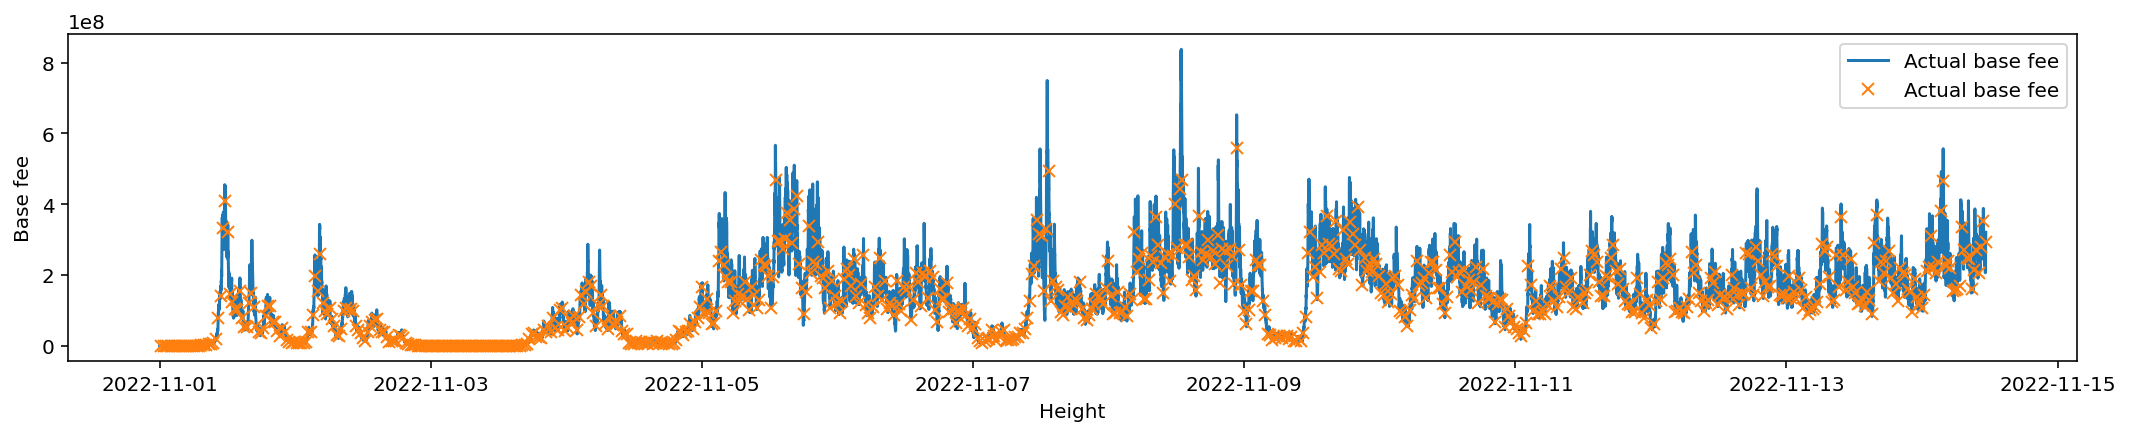

Text(0, 0.5, 'Base fee')

In [0]:
plt.figure(figsize=(18,3))
plt.plot(df_blocks.ts, df_blocks.base_fee, label='Actual base fee')
plt.plot(df_blocks.ts[::50], df_blocks.next_fee[::50], lw=0, marker='x', label='Calculated new base fee')
plt.legend(loc='best')
plt.xlabel('Height')
plt.ylabel('Base fee')

Note the overlap between the two, which indicates that we have successfully predicted the actual base fee from existing data.